In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense,Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = 'dataset/train'
testing_path = 'dataset/testing'

In [3]:
#this part is for getting images and storing it to train_batches

train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes = ['infected','not infected'],batch_size = 10)
testing_batches = ImageDataGenerator().flow_from_directory(testing_path,target_size=(224,224),classes=['infected','not infected'],batch_size=25)

#augment training dataset

#rotate 90
rotate90_gen = ImageDataGenerator(rotation_range=90)
rotate90_batches = rotate90_gen.flow_from_directory(train_path,target_size=(224,224),classes=['infected','not infected'],batch_size=10)   

#rotate 180
rotate180_gen = ImageDataGenerator(rotation_range=180)
rotate180_batches = rotate180_gen.flow_from_directory(train_path,target_size=(224,224),classes=['infected','not infected'],batch_size=10)   

#rotate 270
rotate270_gen = ImageDataGenerator(rotation_range=270)
rotate270_batches = rotate270_gen.flow_from_directory(train_path,target_size=(224,224),classes=['infected','not infected'],batch_size=10)

#vertical flip
vertical_gen = ImageDataGenerator(vertical_flip=True)
vertical_batches = vertical_gen.flow_from_directory(train_path,target_size=(224,224),classes=['infected','not infected'],batch_size=10)   

#horizontal flip
horizontal_gen = ImageDataGenerator(horizontal_flip = True)
horizontal_batches = horizontal_gen.flow_from_directory(train_path,target_size=(224,224),classes=['infected','not infected'],batch_size=10)   


Found 75 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [4]:
#this part is for printing image and label within jupyter

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


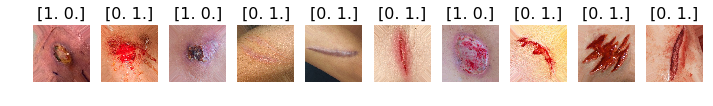

In [5]:
#this part is for testing if images were taken w/ right label
img,label = next(rotate90_batches)
plots(img,titles = label)

In [6]:
#load model

from keras.models import load_model
new_model = load_model('wound_classifier.h5')
new_model.summary()





Instructions for updating:
keep_dims is deprecated, use keepdims instead



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model_file('wound_classifier.h5')
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

print("Conversion FINSIHED!")

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 32 variables.
INFO:tensorflow:Converted 32 variables to const ops.
Conversion FINSIHED!


In [8]:
for layer in new_model.layers:
    layer.trainable = True

print("FINISHED!")

FINISHED!


In [7]:
#initialize VGG16 model

vgg16_model = keras.applications.vgg16.VGG16()
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
#Initialize New Model From VGG16

new_model = Sequential()
for layer in vgg16_model.layers[:-1]:
    layer.trainable = False
    new_model.add(layer)

new_model.add(Dense(2,activation='softmax'))
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
#setup CNN model for training

new_model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
#train CNN model

new_model.fit_generator(train_batches,steps_per_epoch=8,epochs=7,verbose=1)

Epoch 1/7
8/8 [==============================] - 12s 1s/step - loss: 9.7486e-04 - acc: 1.0000
Epoch 2/7
8/8 [==============================] - 11s 1s/step - loss: 8.7132e-04 - acc: 1.0000
Epoch 3/7
8/8 [==============================] - 11s 1s/step - loss: 8.7778e-04 - acc: 1.0000
Epoch 4/7
8/8 [==============================] - 12s 1s/step - loss: 8.3648e-04 - acc: 1.0000
Epoch 5/7
8/8 [==============================] - 12s 1s/step - loss: 8.0707e-04 - acc: 1.0000
Epoch 6/7
8/8 [==============================] - 11s 1s/step - loss: 6.9981e-04 - acc: 1.0000
Epoch 7/7
8/8 [==============================] - 11s 1s/step - loss: 7.1143e-04 - acc: 1.0000


In [18]:
#train CNN model on Augmentation Data

new_model.fit_generator(rotate90_batches,steps_per_epoch=8,epochs=5,verbose=1)
new_model.fit_generator(rotate180_batches,steps_per_epoch=8,epochs=5,verbose=1)
new_model.fit_generator(rotate270_batches,steps_per_epoch=8,epochs=5,verbose=1)
new_model.fit_generator(vertical_batches,steps_per_epoch=8,epochs=5,verbose=1)
new_model.fit_generator(horizontal_batches,steps_per_epoch=8,epochs=5,verbose=1)

Epoch 1/5
8/8 [==============================] - 11s 1s/step - loss: 0.0996 - acc: 0.9385
Epoch 2/5
8/8 [==============================] - 11s 1s/step - loss: 0.0788 - acc: 0.9748
Epoch 3/5
8/8 [==============================] - 11s 1s/step - loss: 0.0778 - acc: 0.9622
Epoch 4/5
8/8 [==============================] - 11s 1s/step - loss: 0.0169 - acc: 1.0000
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 0.0294 - acc: 0.9874
Epoch 1/5
8/8 [==============================] - 11s 1s/step - loss: 0.0362 - acc: 0.9874
Epoch 2/5
8/8 [==============================] - 12s 1s/step - loss: 0.1070 - acc: 0.9637
Epoch 3/5
8/8 [==============================] - 12s 1s/step - loss: 0.0479 - acc: 0.9874
Epoch 4/5
8/8 [==============================] - 12s 1s/step - loss: 0.0177 - acc: 0.9874
Epoch 5/5
8/8 [==============================] - 12s 1s/step - loss: 0.0555 - acc: 0.9748
Epoch 1/5
8/8 [==============================] - 12s 2s/step - loss: 0.0649 - acc: 0.9622
Epoch 2/5


In [21]:
#predict with model

test_imgs,test_labels = next(testing_batches)

testing_labels = []
prediction_labels =[]

for i in range(len(test_labels)):
    point = test_labels[i]
    testing_labels.append(point[0])
    
predictions = new_model.predict_generator(testing_batches,steps=1,verbose=1)

for i in range(len(predictions)):
    point = predictions[i]
    prediction_labels.append(round(point[0]))
    
print(testing_labels)
print(prediction_labels)

error_count = 0

for i in range(len(prediction_labels)):
    if(prediction_labels[i] != testing_labels[i]):
        error_count += 1
           
print("ERROR COUNT",error_count)

1/1 [==============================] - 3s 3s/step
[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
ERROR COUNT 3


In [60]:
#save model

new_model.save('wound_classifier.h5')